In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import cartopy.crs as ccrs
import netCDF4
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import joblib
from scipy import stats
%matplotlib inline

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=36,
                     processes=36, memory="375GB",
                     project='P93300641',
                     walltime='2:30:00')
cluster.scale(36)
client = Client(cluster)

In [3]:
#for use on Cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=36,
                     processes=36, memory="109GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='02:00:00')
cluster.scale(36)
client = Client(cluster)

In [8]:
client
#client.close()

Client Scheduler: tcp://10.148.10.15:42921 Dashboard: http://10.148.10.15:8787/status,Cluster Workers: 36 Cores: 36 Memory: 109.08 GB


### Some functions for DATA I/O, etc

In [9]:
## read in the ensemble of fullgrid output
def get_fullgrid(cases,data_vars):
    def preprocess(ds):
        '''specify a smaller set of data_vars'''
        return ds[data_vars]
    ds_list = []
    for thiscase in cases:
        datadir = '/glade/scratch/oleson/archive/'+thiscase+'/lnd/hist/'
        thisvar  = 'GPP'
        thistape = 'h0' 
        files = sorted(glob.glob(datadir+'*'+thistape+'*'))
        ds=xr.open_mfdataset(files,combine='by_coords',decode_times=False,
                             preprocess=preprocess,parallel=True)
        time_vec0   = xr.cftime_range('2005',periods=120,freq='MS')
        ds['time'] = time_vec0
        ds_list.append(ds)
    ds = xr.concat(ds_list,dim='ens')   
    ds0 = xr.open_dataset(files[0])
    landarea = ds0['area']*ds0['landfrac']
    nlat = len(ds0['lat'])
    nlon = len(ds0['lon'])
    
    return ds,landarea,nlat,nlon

In [10]:
# create paint-by-number maps for a given sparsegrid
def get_maps(nc,fullgrid):
    
    # nc        = number of clusters, e.g. 300
    # fullgrid  = the field you are trying to interpolate
    
    thedir = '/glade/u/home/forrest/ppe_representativeness/output_v3/'
    file   = 'clusters.clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.annual+sd.'+str(nc)+'.nc'
    cc     = thedir+file
    cset = xr.open_dataset(cc)

    ixc = cset.rcent>0
    xx  = cset.rcent.where(ixc).values
    cset_map = xx[~np.isnan(xx)].astype(int)

    sparsemaps = []
    for ee in fullgrid['ens']:

        xx = fullgrid.sel(ens=ee).where(ixc).values
        xx = xx[~np.isnan(xx)]

        thismean = np.zeros(nc+1)
        thismean[cset_map] = xx

        datamap  = np.zeros([nlat,nlon])+np.nan
        for i in 1+np.arange(nc):
            ix = cset['cclass'].values==i
            datamap[ix] =thismean[i]   

        sparsemaps.append(datamap)
    
    return sparsemaps

In [11]:
# COLORBREWER, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

### Gridcell output

In [12]:
data_vars =['GPP','QVEGT','TWS']
cases = ['clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_CON_2000',
         'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_OAAT0001_2000',
         'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_OAAT0002_2000',
         'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_OAAT0003_2000',
         'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_OAAT0004_2000',
         'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_OAAT0005_2000',
         'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_OAAT0006_2000']
ds,landarea,nlat,nlon = get_fullgrid(cases,data_vars)

                     proportional effect on GPP, full grid


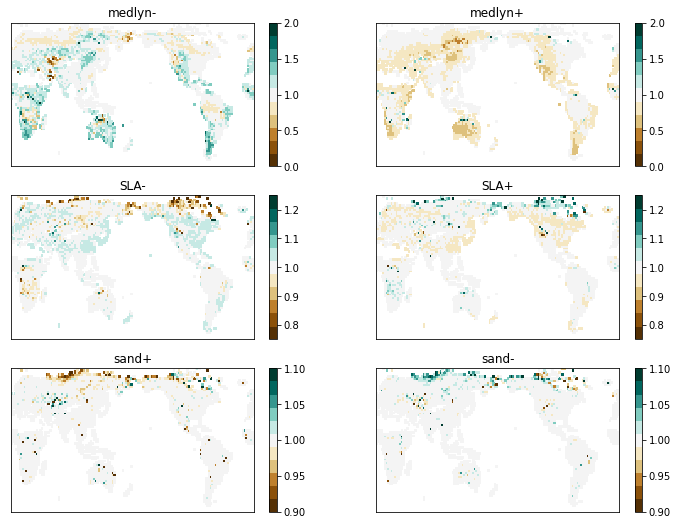

In [18]:
print('                     proportional effect on GPP, full grid')
lgd = ['CON','medlyn-','medlyn+','SLA-','SLA+','sand+','sand-']
vmins = [0,0,0,0.75,0.75,0.9,0.9]
vmaxs = [0,2,2,1.25,1.25,1.1,1.1]
the_means = ds['GPP'].mean(dim=['time']).load()
plt.figure(figsize=[12,9])
for i in 1+np.arange(6):
    plt.subplot(3,2,i)
    eff = the_means.sel(ens=i)/the_means.sel(ens=0)
    ix  = the_means.sel(ens=0)>1e-6
    plt.pcolormesh(eff.where(ix),vmin=vmins[i],vmax=vmaxs[i],cmap=ccc)
    plt.title(lgd[i])
    plt.ylim([15,90])
    plt.yticks([])
    plt.xticks([])
    plt.colorbar()

          fullgrid: absolute effect on GPP (MtC/yr) (accounts for area)


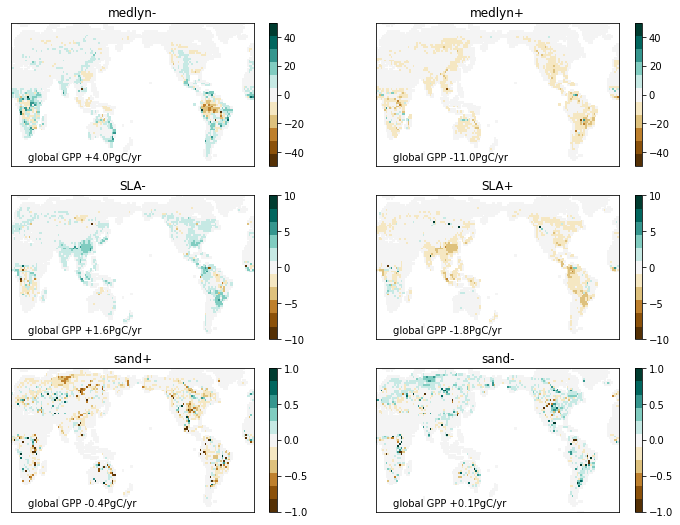

In [20]:
print('          fullgrid: absolute effect on GPP (MtC/yr) (accounts for area)')
xf = 365*24*60*60*1e-6
gpp_ann = xf*landarea*the_means   #MtC/yr
vmins = [0,-50,-50,-10,-10,-1,-1]
vmaxs = [0,50,50,10,10,1,1]
plt.figure(figsize=[12,9])
for i in 1+np.arange(6):
    plt.subplot(3,2,i)
    eff = gpp_ann.sel(ens=i)-gpp_ann.sel(ens=0)
    mtc = np.round(np.nansum(eff)/1e3,1)
    if mtc>=0:
        mtc = '+'+str(mtc)
    else:
        mtc = str(mtc)
    plt.pcolormesh(eff,vmin=vmins[i],vmax=vmaxs[i],cmap=ccc)
    plt.text(10,18,'global GPP '+mtc+'PgC/yr')
    plt.title(lgd[i])
    plt.ylim([15,90])
    plt.yticks([])
    plt.xticks([])
    plt.colorbar()

In [22]:
nc = 500
fullgrid = ds['GPP'].mean(dim='time')
sparsemaps = get_maps(nc,fullgrid)
thedir = '/glade/u/home/forrest/ppe_representativeness/output_v3/'
file   = 'clusters.clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.annual+sd.'+str(nc)+'.nc'
cc     = thedir+file
cset = xr.open_dataset(cc)
landarea = cset['area']*cset['landfrac']  #includes antarctica mask

                        sanity check: compare CONTROL run GPP


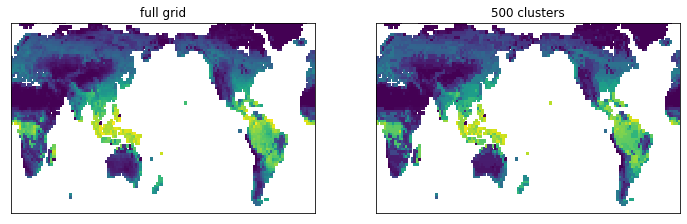

In [23]:
print('                        sanity check: compare CONTROL run GPP')
plt.figure(figsize=[12,3.5])
plt.subplot(121)
plt.pcolormesh(fullgrid.sel(ens=0),vmin=0,vmax=0.00012)
plt.ylim([15,90])
plt.yticks([])
plt.xticks([])
plt.title('full grid')

plt.subplot(122)
plt.pcolormesh(sparsemaps[0],vmin=0,vmax=0.00012)
plt.ylim([15,90])
plt.yticks([])
plt.xticks([])
plt.title('500 clusters');


          500clusters: absolute effect on GPP (MtC/yr) (accounts for area)


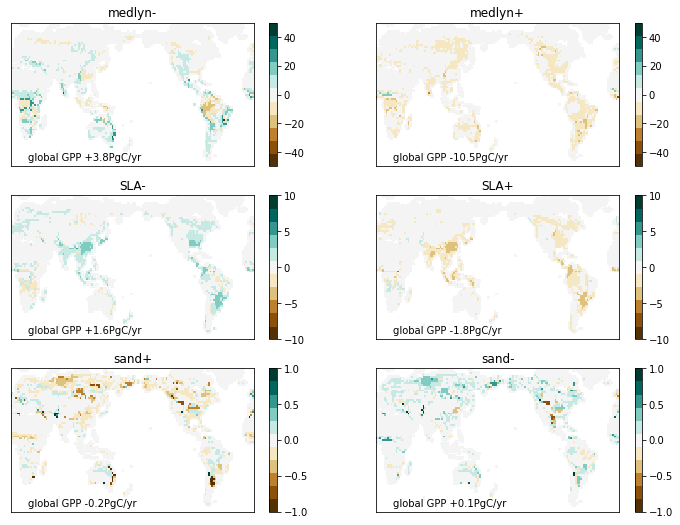

In [25]:
plt.figure(figsize=[12,9])
print('          500clusters: absolute effect on GPP (MtC/yr) (accounts for area)')
xf = 365*24*60*60*1e-6 
vmins = [0,-50,-50,-10,-10,-1,-1]
vmaxs = [0,50,50,10,10,1,1]
for i in 1+np.arange(6):
    eff = xf*landarea*sparsemaps[i]-xf*landarea*sparsemaps[0]
    mtc = np.round(np.nansum(eff)/1e3,1)
    if mtc>=0:
        mtc = '+'+str(mtc)
    else:
        mtc = str(mtc)

    plt.subplot(3,2,i)
    plt.pcolormesh(eff,cmap=ccc,vmin=vmins[i],vmax=vmaxs[i])
    plt.text(10,18,'global GPP '+mtc+'PgC/yr')
    plt.colorbar()
    plt.title(lgd[i])
    plt.ylim([15,90])
    plt.yticks([])
    plt.xticks([])

In [41]:
fullgrid = ds['GPP'].mean(dim='time')
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))
clustermaps = []
for nc in clusters:
    sparsemaps = get_maps(nc,fullgrid)
    clustermaps.append(sparsemaps)

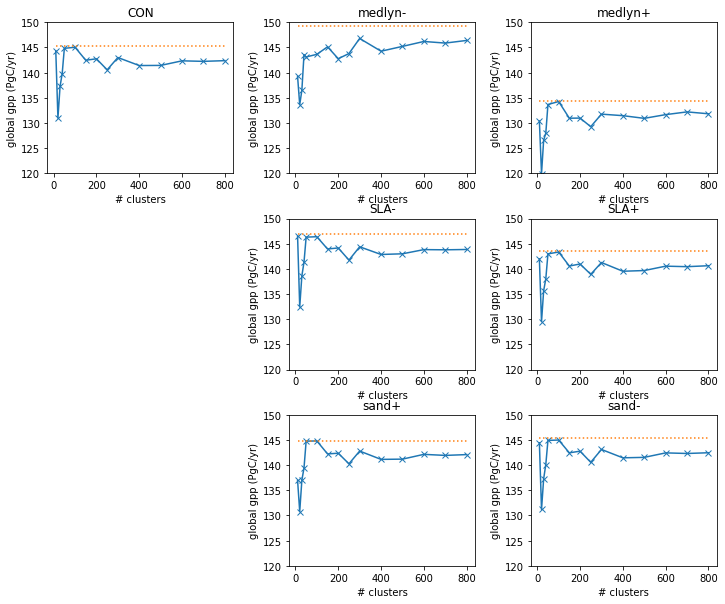

In [42]:
nx = 7
i = -1
xf = 365*24*60*60*1e-9
out = np.zeros([15,nx])
for sparsemaps in clustermaps:
    i +=1
    for j in range(nx):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

plt.figure(figsize=[12,10])
pp=[1,2,3,5,6,8,9]
for i in range(nx):
    plt.subplot(3,3,pp[i])
    thisgrid = np.nansum(xf*landarea*fullgrid.sel(ens=i)) #PgC
    plt.plot(clusters,out[:,i],'-x')
    plt.plot(clusters,np.tile(thisgrid,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel('global gpp (PgC/yr)')
    plt.xlabel('# clusters');
    plt.ylim([120,150])
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

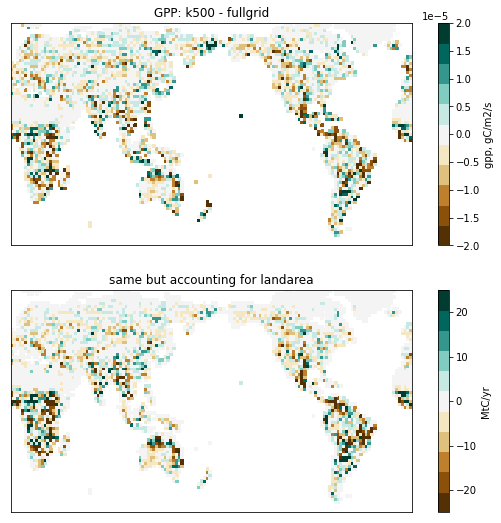

In [43]:
## difference the 500 cluster map and the full grid for the control run
sparsemaps = get_maps(500,fullgrid)
diffmap = sparsemaps[0]-fullgrid.sel(ens=0).values
diff2   = 365*24*60*60*landarea*diffmap*1e-6

plt.figure(figsize=[9,9])
plt.subplot(211)
plt.pcolormesh(diffmap,vmin=-2e-5,vmax=2e-5,cmap=ccc)
plt.colorbar(label='gpp, gC/m2/s')
plt.title('GPP: k500 - fullgrid')
plt.xticks([])
plt.yticks([])
plt.ylim([15,90])

plt.subplot(212)
plt.pcolormesh(diff2,vmin=-25,vmax=25,cmap=ccc)
plt.colorbar(label='MtC/yr')
plt.title('same but accounting for landarea')
plt.xticks([])
plt.yticks([])
plt.ylim([15,90]);


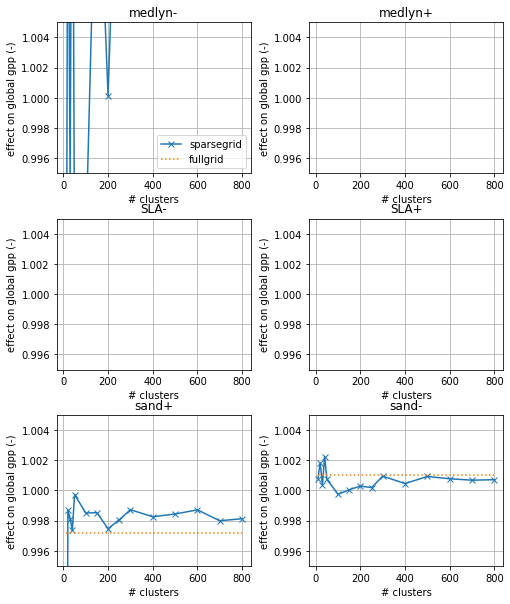

In [47]:
i = -1
nx=7
xf = 365*24*60*60*1e-9
out = np.zeros([15,nx])
for sparsemaps in clustermaps:
    i +=1
    for j in range(nx):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

fullgridcon = np.nansum(xf*landarea*the_means.sel(ens=0)) #PgC        

plt.figure(figsize=[8,10])
for i in 1+np.arange(nx-1):
    plt.subplot(3,2,i)
    eff = out[:,i]/out[:,0]
    fulleff = np.nansum(xf*landarea*the_means.sel(ens=i))/fullgridcon
    plt.plot(clusters,eff,'-x')
    plt.plot(clusters,np.tile(fulleff,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel('effect on global gpp (-)')
    plt.xlabel('# clusters');
    plt.ylim([0.995,1.005])
    if i==1:
        plt.legend(['sparsegrid','fullgrid'],loc=4)
    plt.grid()
plt.subplots_adjust(hspace=0.3,wspace=0.3)

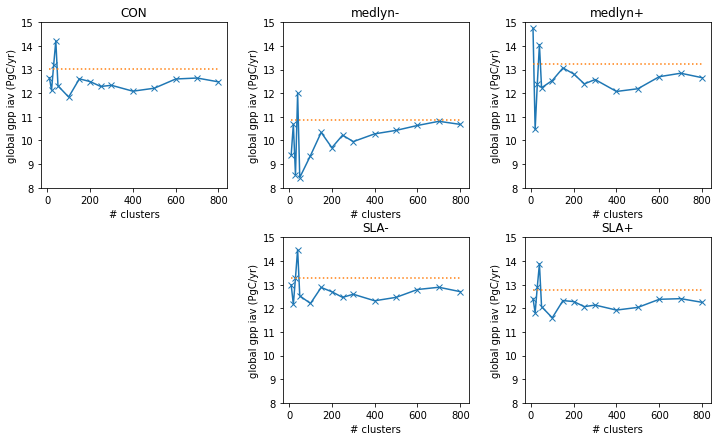

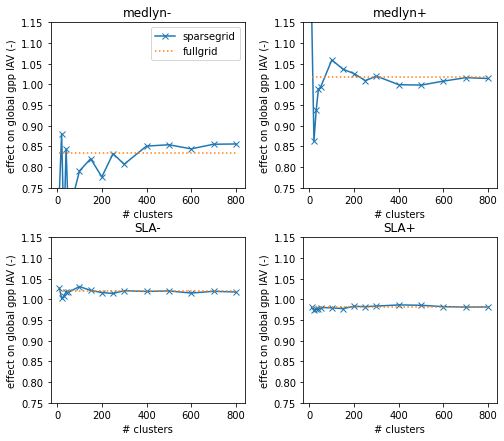

In [57]:
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))
gppiav = ds['GPP'].groupby('time.year').mean(dim='time').std(dim='year').load()
clustermaps = [get_maps(nc,gppiav) for nc in clusters]

i = -1
xf = 365*24*60*60*1e-9
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

plt.figure(figsize=[12,7])
pp=[1,2,3,5,6]
for i in range(5):
    plt.subplot(2,3,pp[i])
    fullgrid = np.nansum(xf*landarea*gppiav.sel(ens=i)) #PgC
    plt.plot(clusters,out[:,i],'-x')
    plt.plot(clusters,np.tile(fullgrid,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel('global gpp iav (PgC/yr)')
    plt.xlabel('# clusters');
    plt.ylim([8,15])
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

i = -1
xf = 365*24*60*60*1e-9
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

fullgridcon = np.nansum(xf*landarea*gppiav.sel(ens=0)) #PgC        

plt.figure(figsize=[8,7])
for i in 1+np.arange(4):
    plt.subplot(2,2,i)
    eff = out[:,i]/out[:,0]
    fulleff = np.nansum(xf*landarea*gppiav.sel(ens=i))/fullgridcon
    plt.plot(clusters,eff,'-x')
    plt.plot(clusters,np.tile(fulleff,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel('effect on global gpp IAV (-)')
    plt.xlabel('# clusters');
    plt.ylim([0.75,1.15])
    if i==1:
        plt.legend(['sparsegrid','fullgrid'],loc=1)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

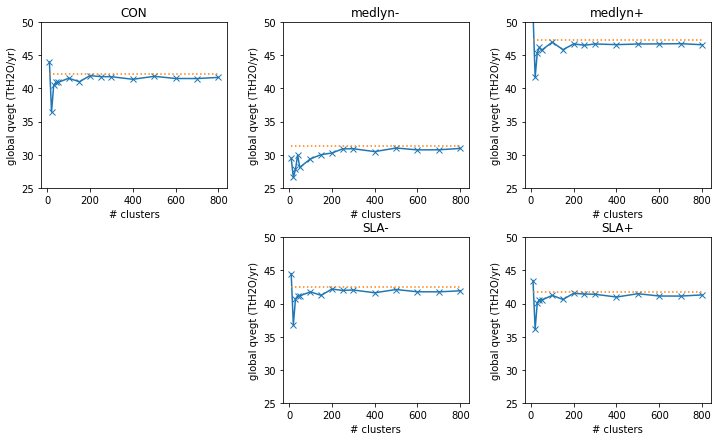

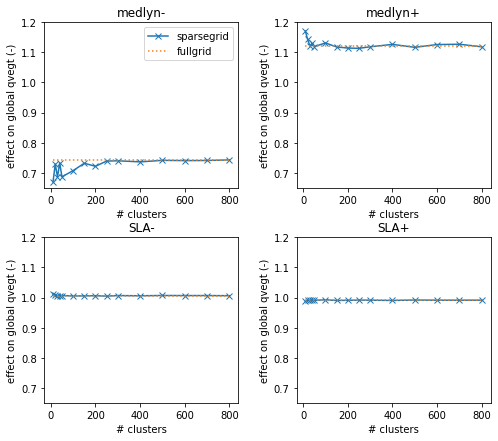

In [64]:
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))
thisvar = 'QVEGT'
thisgrid = ds[thisvar].mean(dim='time').load()
clustermaps = [get_maps(nc,thisgrid) for nc in clusters]
ylab1 = 'global qvegt (TtH2O/yr)'
ylab2 = 'effect on global qvegt (-)'

i = -1
xf = 365*24*60*60*1e-9
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

plt.figure(figsize=[12,7])
pp=[1,2,3,5,6]
for i in range(5):
    plt.subplot(2,3,pp[i])
    fullgrid = np.nansum(xf*landarea*thisgrid.sel(ens=i)) #PgC
    plt.plot(clusters,out[:,i],'-x')
    plt.plot(clusters,np.tile(fullgrid,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab1)
    plt.xlabel('# clusters');
    plt.ylim([25,50])
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

i = -1
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

fullgridcon = np.nansum(xf*landarea*thisgrid.sel(ens=0)) #PgC        

plt.figure(figsize=[8,7])
for i in 1+np.arange(4):
    plt.subplot(2,2,i)
    eff = out[:,i]/out[:,0]
    fulleff = np.nansum(xf*landarea*thisgrid.sel(ens=i))/fullgridcon
    plt.plot(clusters,eff,'-x')
    plt.plot(clusters,np.tile(fulleff,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab2)
    plt.xlabel('# clusters');
    plt.ylim([0.65,1.2])
    if i==1:
        plt.legend(['sparsegrid','fullgrid'],loc=1)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

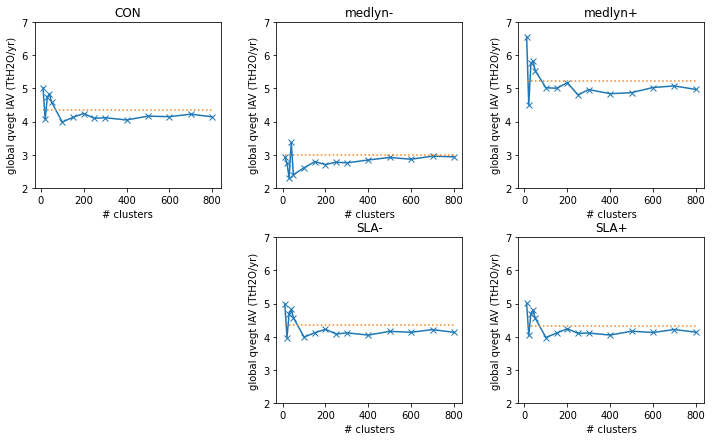

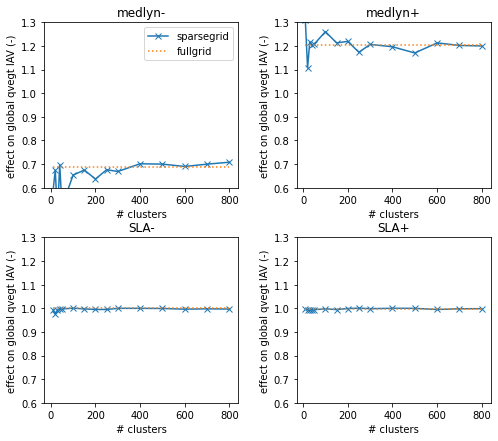

In [68]:
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))
thisvar = 'QVEGT'
thisgrid = ds[thisvar].groupby('time.year').mean(dim='time').std(dim='year').load()
clustermaps = [get_maps(nc,thisgrid) for nc in clusters]
ylab1 = 'global qvegt IAV (TtH2O/yr)'
ylab2 = 'effect on global qvegt IAV (-)'

i = -1
xf = 365*24*60*60*1e-9
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

plt.figure(figsize=[12,7])
pp=[1,2,3,5,6]
for i in range(5):
    plt.subplot(2,3,pp[i])
    fullgrid = np.nansum(xf*landarea*thisgrid.sel(ens=i)) #PgC
    plt.plot(clusters,out[:,i],'-x')
    plt.plot(clusters,np.tile(fullgrid,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab1)
    plt.xlabel('# clusters');
    plt.ylim([2,7])
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

i = -1
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*landarea*sparsemaps[j]) #PgC

fullgridcon = np.nansum(xf*landarea*thisgrid.sel(ens=0)) #PgC        

plt.figure(figsize=[8,7])
for i in 1+np.arange(4):
    plt.subplot(2,2,i)
    eff = out[:,i]/out[:,0]
    fulleff = np.nansum(xf*landarea*thisgrid.sel(ens=i))/fullgridcon
    plt.plot(clusters,eff,'-x')
    plt.plot(clusters,np.tile(fulleff,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab2)
    plt.xlabel('# clusters');
    plt.ylim([0.6,1.3])
    if i==1:
        plt.legend(['sparsegrid','fullgrid'],loc=1)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

In [35]:
maskedlandarea = cset['area']*cset['landfrac'].values

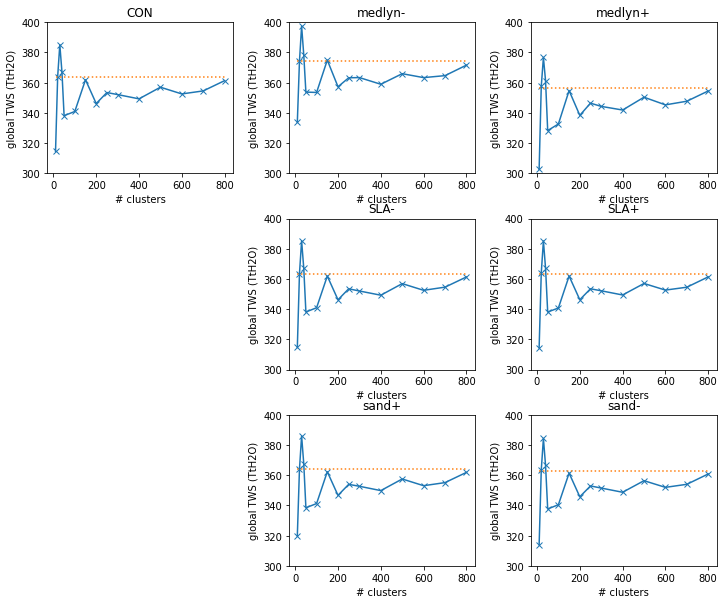

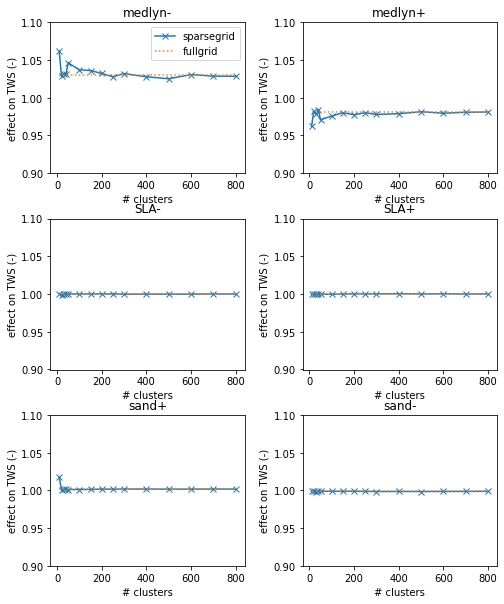

In [38]:
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))
thisvar = 'TWS'
thisgrid = ds[thisvar].mean(dim='time').load()
clustermaps = [get_maps(nc,thisgrid) for nc in clusters]
ylab1 = 'global TWS (TtH2O)'
ylab2 = 'effect on TWS (-)'
nx = 7

i = -1
xf = 1e-9
out = np.zeros([15,nx])
for sparsemaps in clustermaps:
    i +=1
    for j in range(nx):
        out[i,j] = np.nansum(xf*maskedlandarea*sparsemaps[j]) #PgC

plt.figure(figsize=[12,10])
pp=[1,2,3,5,6,8,9]
for i in range(nx):
    plt.subplot(3,3,pp[i])
    fullgrid = np.nansum(xf*maskedlandarea*thisgrid.sel(ens=i)) #PgC
    plt.plot(clusters,out[:,i],'-x')
    plt.plot(clusters,np.tile(fullgrid,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab1)
    plt.xlabel('# clusters');
    plt.ylim([300,400])
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)


fullgridcon = np.nansum(xf*maskedlandarea*thisgrid.sel(ens=0)) #PgC        

plt.figure(figsize=[8,10])
for i in 1+np.arange(nx-1):
    plt.subplot(3,2,i)
    eff = out[:,i]/out[:,0]
    fulleff = np.nansum(xf*maskedlandarea*thisgrid.sel(ens=i))/fullgridcon
    plt.plot(clusters,eff,'-x')
    plt.plot(clusters,np.tile(fulleff,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab2)
    plt.xlabel('# clusters');
    plt.ylim([0.9,1.1])
    if i==1:
        plt.legend(['sparsegrid','fullgrid'],loc=1)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

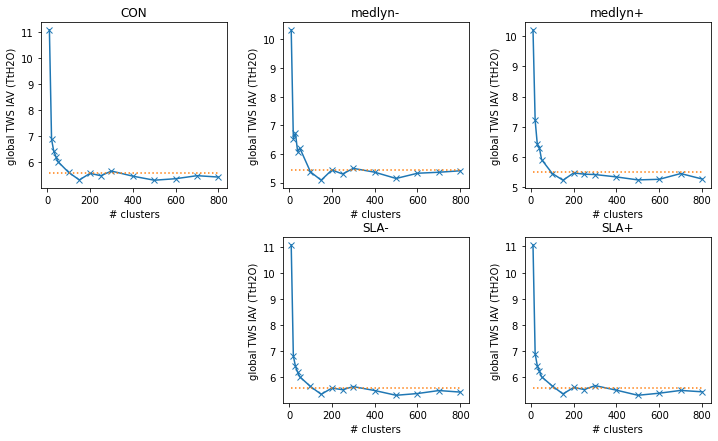

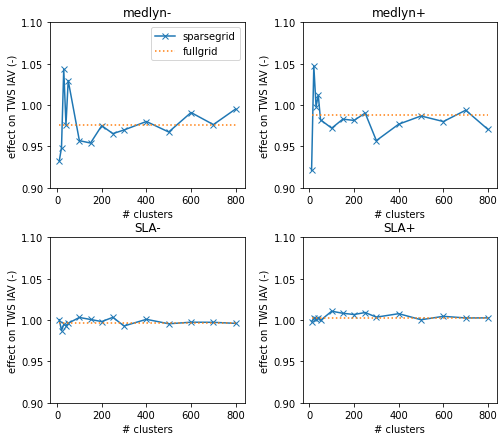

In [100]:
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))
thisvar = 'TWS'
thisgrid = ds[thisvar].groupby('time.year').mean(dim='time').std(dim='year').load()
clustermaps = [get_maps(nc,thisgrid) for nc in clusters]
ylab1 = 'global TWS IAV (TtH2O)'
ylab2 = 'effect on TWS IAV (-)'

i = -1
xf = 1e-9
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*maskedlandarea*sparsemaps[j]) #PgC

plt.figure(figsize=[12,7])
pp=[1,2,3,5,6]
for i in range(5):
    plt.subplot(2,3,pp[i])
    fullgrid = np.nansum(xf*maskedlandarea*thisgrid.sel(ens=i)) #PgC
    plt.plot(clusters,out[:,i],'-x')
    plt.plot(clusters,np.tile(fullgrid,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab1)
    plt.xlabel('# clusters');
    #plt.ylim([300,400])
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

i = -1
out = np.zeros([15,5])
for sparsemaps in clustermaps:
    i +=1
    for j in range(5):
        out[i,j] = np.nansum(xf*maskedlandarea*sparsemaps[j]) #PgC

fullgridcon = np.nansum(xf*maskedlandarea*thisgrid.sel(ens=0)) #PgC        

plt.figure(figsize=[8,7])
for i in 1+np.arange(4):
    plt.subplot(2,2,i)
    eff = out[:,i]/out[:,0]
    fulleff = np.nansum(xf*maskedlandarea*thisgrid.sel(ens=i))/fullgridcon
    plt.plot(clusters,eff,'-x')
    plt.plot(clusters,np.tile(fulleff,len(clusters)),':')
    plt.title(lgd[i])
    plt.ylabel(ylab2)
    plt.xlabel('# clusters');
    plt.ylim([0.9,1.1])
    if i==1:
        plt.legend(['sparsegrid','fullgrid'],loc=1)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)

### What about PFT?

In [72]:
thedir = '/glade/scratch/oleson/archive/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_CON_2000/lnd/hist/'
file = 'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_CON_2000.clm2.h1.2010-01.nc'
ff = thedir+file
ds = xr.open_dataset(ff)
ds['pft']=ds['pfts1d_itype_veg'] #reassign pft variable for easier analysis
pftnames = ['NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3ArG','C3G','C4G','C3C']

In [48]:
pp = 5
ix = ds['pft']==pp
latix = ds['pfts1d_jxy'][ix].values.astype(int)-1
lonix = ds['pfts1d_ixy'][ix].values.astype(int)-1
lats = ds['pfts1d_lat'][ix].values.astype('float32')
lons = ds['pfts1d_lon'][ix].values.astype('float32')
yy = ds['GPP'][0,ix]
alllats = ds['lat']

In [64]:
npft = np.zeros([15,15])
clusters = list(10+10*np.arange(5))+list(100+50*np.arange(5))+list(400+100*np.arange(5))

i = -1
for nc in clusters:
    i +=1
    thedir = '/glade/u/home/forrest/ppe_representativeness/output_v3/'
    file   = 'clusters.clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.annual+sd.'+str(nc)+'.nc'
    cc     = thedir+file
    cset = xr.open_dataset(cc)


    for pp in range(15):
        ix = ds['pft']==pp+1
        lats = ds['pfts1d_lat'][ix].values.astype('float32')
        lons = ds['pfts1d_lon'][ix].values.astype('float32')

        nmatch = 0
        for lon,lat in cset.rcent_coords.values:
            ix = np.logical_and(lat==lats,lon==lons)
            if ix.sum()>0:
                nmatch +=1
        npft[pp,i]=nmatch

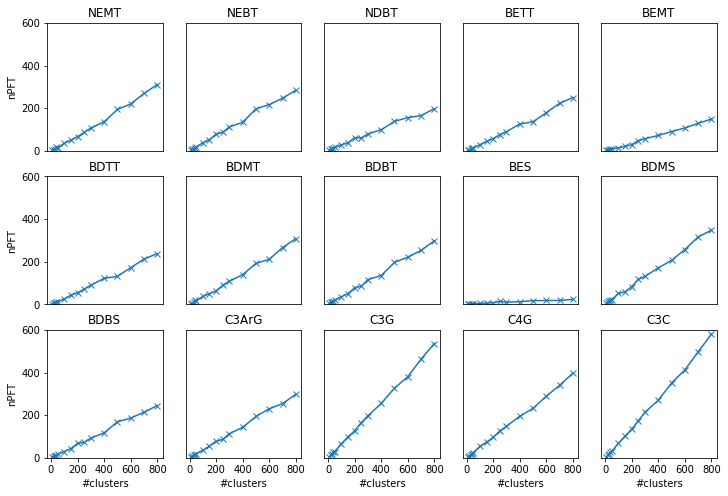

In [78]:
plt.figure(figsize=[12,8])
for pp in range(15):
    plt.subplot(3,5,pp+1)
    plt.plot(clusters,npft[pp,:],'-x')
    plt.title(pftnames[pp])
    plt.ylim([0,600])
    if pp<10:
        plt.xticks([])
    else:
        plt.xticks(200*np.arange(5))
        plt.xlabel('#clusters')
    if (pp==0)|(pp==5)|(pp==10):
        plt.yticks(200*np.arange(4))
        plt.ylabel('nPFT')
    else:
        plt.yticks([])
    

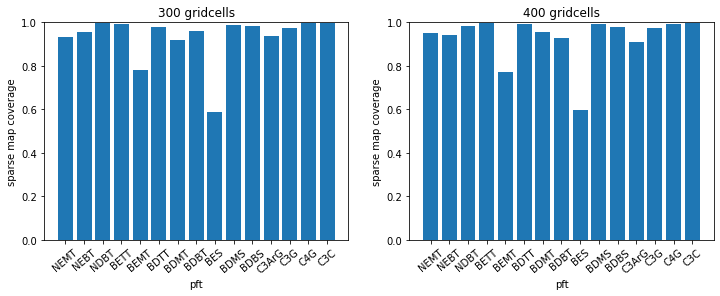

In [139]:
plt.figure(figsize=[12,4])
subsub = 0
for nc in [300,400]:
    subsub +=1
    plt.subplot(1,2,subsub)
    pftmaps = [np.zeros([nlat,nlon])+np.nan for i in range(16)] #initialize output maps:
    thedir = '/glade/u/home/forrest/ppe_representativeness/output_v3/'
    file   = 'clusters.clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.annual+sd.'+str(nc)+'.nc'
    cc     = thedir+file
    cset = xr.open_dataset(cc)
    clons = [x[0] for x in cset.rcent_coords.values]
    clats = [x[1] for x in cset.rcent_coords.values]
    i = 0
    lats = ds['pfts1d_lat'].values.astype('float32')
    lons = ds['pfts1d_lon'].values.astype('float32')
    for i,lon,lat in zip(1+np.arange(nc),clons,clats):
        ix = np.logical_and(lat==lats,lon==lons)
        pftlist = ds['pft'][ix].values.astype(int)
        pftlist = pftlist[pftlist>0]
        for pp in pftlist:
            if pp<16:
                ix = cset.cclass.values==i
                pftmaps[pp][ix]=1
    pftwts  = [np.zeros([nlat,nlon])+np.nan for i in range(16)] #initialize output maps
    ix = np.logical_and(ds['pft']>0,ds['pft']<16)
    lats = ds['pfts1d_jxy'].values[ix].astype(int)-1
    lons = ds['pfts1d_ixy'].values[ix].astype(int)-1
    pfts = ds['pft'].values[ix].astype(int)
    wts  = ds['pfts1d_wtgcell'].values[ix]
    for lat,lon,pp,wt in zip(lats,lons,pfts,wts):
        pftwts[pp][lat,lon]=wt
    represented_area = np.zeros(15)
    for pp in 1+np.arange(15):
        pftarea = cset['area']*cset['landfrac']*pftwts[pp]
        sparsetot = np.nansum(pftmaps[pp]*pftarea)
        fulltot = np.nansum(pftarea)
        represented_area[pp-1]=sparsetot/fulltot
    plt.bar(np.arange(15),represented_area)
    plt.title(str(nc)+' gridcells')
    plt.ylabel('sparse map coverage')
    plt.xlabel('pft')
    plt.xticks(np.arange(15),pftnames,rotation=40)
    plt.ylim([0,1]);

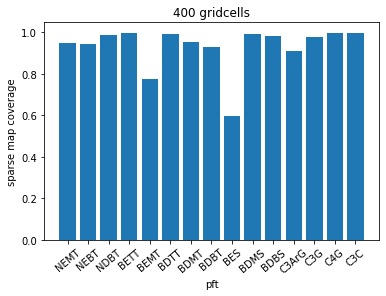

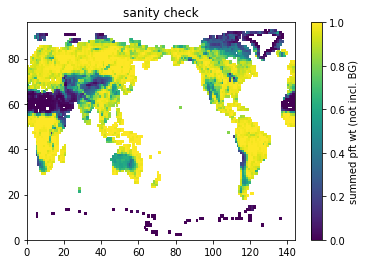

In [122]:
totwt = np.zeros([nlat,nlon])
for pp in 1+np.arange(15):
    ix = ~np.isnan(pftwts[pp])
    totwt[ix] = totwt[ix] + pftwts[pp][ix]
totwt[totwt==0]=np.nan
plt.pcolormesh(totwt,vmin=0,vmax=1)
plt.title('sanity check')
plt.colorbar(label='summed pft wt (not incl. BG)')

In [44]:
# what is the effect on mean GPP by pft on average/ in aggregate (fullgrid)?

In [51]:
# what is the effect on mean GPP by pft on average (sparsegrid)?

In [46]:
# how to create an aggregate for sparsegrid when you're missing the paint by number?

In [47]:
# what are the chances that the centroid samples your pft?

In [100]:
pdir = '/glade/scratch/djk2120/mini_ens/paramfiles/'
paths = sorted(glob.glob(pdir+'*.nc'))
params = xr.open_dataset(paths[0])

In [102]:
params['pftname'].values

array([b'not_vegetated                           ',
       b'needleleaf_evergreen_temperate_tree     ',
       b'needleleaf_evergreen_boreal_tree        ',
       b'needleleaf_deciduous_boreal_tree        ',
       b'broadleaf_evergreen_tropical_tree       ',
       b'broadleaf_evergreen_temperate_tree      ',
       b'broadleaf_deciduous_tropical_tree       ',
       b'broadleaf_deciduous_temperate_tree      ',
       b'broadleaf_deciduous_boreal_tree         ',
       b'broadleaf_evergreen_shrub               ',
       b'broadleaf_deciduous_temperate_shrub     ',
       b'broadleaf_deciduous_boreal_shrub        ',
       b'c3_arctic_grass                         ',
       b'c3_non-arctic_grass                     ',
       b'c4_grass                                ',
       b'c3_crop                                 ',
       b'c3_irrigated                            ',
       b'temperate_corn                          ',
       b'irrigated_temperate_corn                ',
       b'spr